In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set_context("paper")
from matplotlib.lines import Line2D
from labellines import labelLine, labelLines

import pandas as pd

import scipy.stats
from scipy.stats import t, pearsonr

from multi_task.model_explorer import ModelExplorer

KS_NAME = "Kolmogorov-Smirnov Difference"

/tmp/ipykernel_13738/360197246.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


# CIFAR-10

## KS Distribution plot

In [25]:
layers = range(0, 15)
networks = ["", "2", "3", "4", "5"]
df_list = []
for n in networks:
    for l in layers:
        ks_diff_path = f"wasser_dists/wasser_ks_diff_attr_hist_bettercifar10single{n}_{l}.npy"
        ks_diff = np.load(ks_diff_path, allow_pickle=True).item()
        df = pd.DataFrame.from_dict(ks_diff)
        df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: KS_NAME})
        df["Layer"] = int(l)+2
        df["Network"] = int(n) if n != "" else 1
        df = df[["Network", "Layer", "Neuron", "Class", KS_NAME]]
        df_list.append(df)
df_ks_cifar = pd.concat(df_list)
df_ks_cifar

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference
0,1,2,0,0,0.423823
1,1,2,0,1,-0.106508
2,1,2,0,2,-0.116964
3,1,2,0,3,0.112857
4,1,2,0,4,-0.238270
...,...,...,...,...,...
5115,5,16,511,5,0.561010
5116,5,16,511,6,-0.265932
5117,5,16,511,7,-0.491163
5118,5,16,511,8,0.620693


In [26]:
def plot_ksd_distribution(df, title_suffix='', bw=0.05):
    g = sns.violinplot(data=df, x="Layer", y=KS_NAME, bw=bw, inner=None, color="black")
    title_suffix = f" {title_suffix}" if title_suffix != '' else ''
    g.set(ylim=(-1, 1))
    g.set_title(f"{KS_NAME}{title_suffix}", fontsize='large')
    g.set(ylabel="")
    sns.despine()

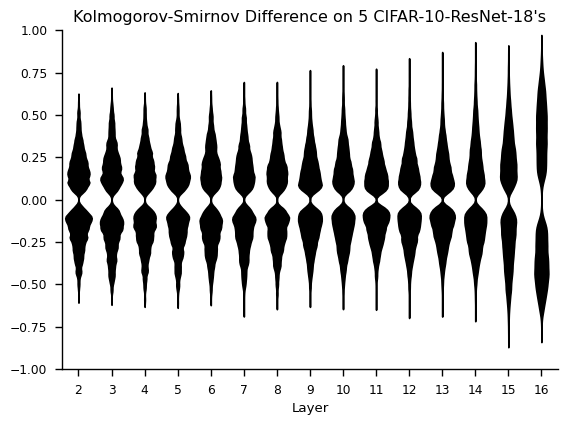

In [27]:
plot_ksd_distribution(df_ks_cifar, title_suffix="on 5 CIFAR-10-ResNet-18's")

## Proportion plot

In [28]:
# def compute_df_props(df, threshold=0.25):
#     # Filter with treshold
#     df_proportions = df.copy()
#     df_proportions[f"KS-D < {threshold}"] = df_proportions[KS_NAME] < -threshold
#     df_proportions[f"KS-D > {threshold}"] = df_proportions[KS_NAME] > threshold
    
#     df_proportions_counted = df_proportions.groupby(["Network", "Layer", "Neuron"]).sum()

#     df_prop_list = []
#     for crit in ["<", ">"]:
#         df_proportions_ks_neurons_counted = df_proportions_counted.reset_index()[["Network", "Layer", f"KS-D {crit} {threshold}", "Neuron"]].groupby(["Network", "Layer", f"KS-D {crit} {threshold}"]).count().reset_index().rename(columns={"Neuron": "Neurons with class count"})

#         df_proportions_neurons_counted = df_proportions_counted.reset_index()[["Network", "Layer", "Neuron"]].groupby(["Network", "Layer"]).count().reset_index().rename(columns={"Neuron": "Neurons in layer"})

#         df_counts_merged = pd.merge(df_proportions_ks_neurons_counted, df_proportions_neurons_counted, on=["Network", "Layer"])

#         df_counts_merged["Proportion of neurons"] = df_counts_merged["Neurons with class count"] / df_counts_merged["Neurons in layer"]
#         df_counts_merged = df_counts_merged.rename(columns={f"KS-D {crit} {threshold}": "Number of classes"})
#         df_counts_merged["Criterion"] = f"KS-D {crit} {threshold}"
#         df_prop_list.append(df_counts_merged)

#     df_props = pd.concat(df_prop_list)

#     df_props["Proportion of neurons (cumsum)"] = df_props.groupby(["Network", "Layer", "Criterion"]).agg({"Proportion of neurons": 'cumsum'})
#     return df_props

def plot_ksd_proportion_cifar10(df, threshold=0.25, plot_cumsum=True):
    df_props = compute_df_props(df, threshold=threshold)

    nclasses = df_props["Number of classes"].unique()[:-1]
    nclasses.sort()
    # return nclasses

    cp = sns.color_palette("blend:#FFF,#000", len(nclasses))
    cp.append("red")
    cp.reverse()
    SO = [f"KS-D > {threshold}", f"KS-D < {threshold}"]

    y = "Proportion of neurons (cumsum)" if plot_cumsum else "Proportion of neurons"
    loc = "lower center" if plot_cumsum else "upper center"

    ylabel = "Proportion of neurons with $\\leq n$ classes\nfulfilling the criterion" if plot_cumsum else "Proportion of neurons with exactly $n$ classes\nfulfilling the criterion"

    xvals= [15.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 15.5, 0.0, 16.0, 0.0] if plot_cumsum else [2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.6, 2.0, 0.0, 14.5, 0.0, 15.5, 0.0]

    for n in nclasses:
        sns.lineplot(data=df_props[df_props["Number of classes"] == n], x="Layer", y=y, style="Criterion", style_order=SO, errorbar=None, color=cp[n], label=f"{n}", legend=False)
    l = plt.gca().get_lines()

    xvals_cleared = []
    for (i, x) in enumerate(xvals):
        if x == 0:
            l[i].set_label("")
        else:
            xvals_cleared.append(x)

    labelLines(l, align=False, xvals=xvals_cleared);
    custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
                    Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
                    ]
    plt.gca().legend(custom_lines, SO, ncols=2, loc=loc, frameon=False, title="Criterion")
    plt.gca().set(ylabel=ylabel)
    sns.despine()

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.175),(2,0.175),...,(16,0.00078125)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.459375),(2,0.459375),...,(16,0.00898437)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.809375),(2,0.809375),...,(16,0.059375)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.996875),(2,0.996875),...,(16,0.310547)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/sit

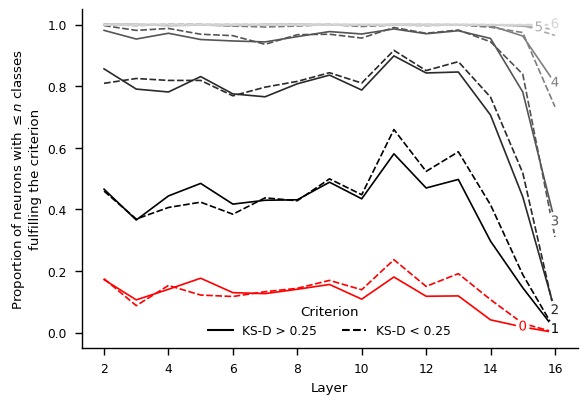

In [29]:
plot_ksd_proportion_cifar10(df_ks_cifar)

## Outline histogram plot

In [13]:
acts_5_103 = np.load("attr_hist_cifar_for_paper/acts_5_103ks_diff.npy", allow_pickle=True).item()
df_acts_5_103 = pd.DataFrame(acts_5_103)

df_list = []
for c in df_acts_5_103.columns:
    for r in df_acts_5_103.index:
        acts = pd.Series(df_acts_5_103[c][r])
        df = pd.DataFrame(data={"Activations": acts, "Class": c, "Type": r})
        df_list.append(df)
df_acts_5_103 = pd.concat(df_list)

In [14]:
df_acts_5_103

,Activations,Class,Type
0,0.102734,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
1,0.098903,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
2,0.089662,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
3,0.094284,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
4,0.223361,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
...,...,...,...
1010,0.134426,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class
1011,0.167308,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class
1012,0.099572,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class
1013,0.229609,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class


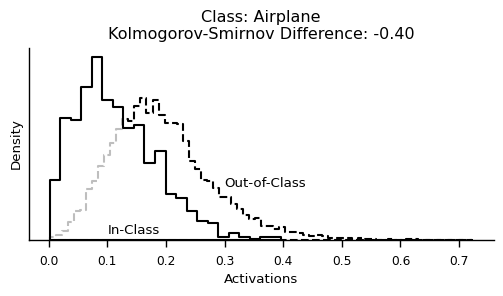

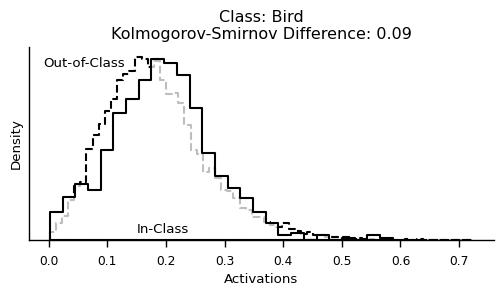

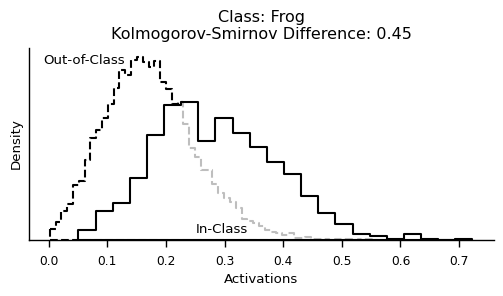

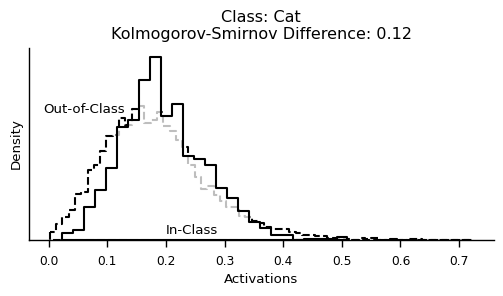

In [181]:
label_positions = {
    "Airplane": ((0.1, 0.25), (0.3, 2.0)),
    "Bird": ((0.15, 0.2), (-0.01, 4.8)),
    "Frog": ((0.25, 0.2), (-0.01, 5.1)),
    "Cat": ((0.2, 0.25), (-0.01, 4.8)),
}

for c in ["Airplane", "Bird", "Frog", "Cat"]:
    df_data = df_acts_5_103[df_acts_5_103["Class"].str.contains(c)]

    linestyles = ["--", "-"]
    f, ax = plt.subplots(figsize=(6, 2.5))
    for (i, t) in enumerate(df_data["Type"].unique()):
        df_data_type = df_data[df_data["Type"] == t]
        sns.histplot(ax=ax, data=df_data_type, x="Activations", color="white", element="step", fill=True, linestyle=linestyles[i], label=t, stat="density", edgecolor="black", linewidth=1.5)
    p = plt.gca()
    p.annotate("In-Class", (0.0, 0.0), label_positions[c][0], fontsize="medium");
    p.annotate("Out-of-Class", (0.0, 0.0), label_positions[c][1], fontsize="medium");
    p.set(yticklabels=[], yticks=[])
    p.set_title(df_data["Class"][0].to_list()[0].replace("Diff.", "Difference"), fontsize='large')
    # p.text(*label_positions[c][2], df_data["Class"][0].to_list()[0], fontsize="large");
    sns.despine()
    plt.show()

## Gradient correlation plot

In [143]:
networks = ["", "2", "3", "4", "5"]
df_list = []
for n in networks:
    df_j_cifar = pd.read_pickle(f"local_storage/grads_bettercifar10single{n}_afterrelu_val_all_samples.pkl")
    df_j_cifar = df_j_cifar.melt(id_vars=["layer_name", "neuron_idx"], var_name="Class", value_name="Avg. Jacobian").rename(columns={"layer_name": "Layer", "neuron_idx": "Neuron"})

    k = df_j_cifar["Layer"].unique()
    v = np.arange(len(df_j_cifar["Layer"].unique()))+2
    ln_map = {k_:v_ for k_, v_ in zip(k, v)}

    df_j_cifar["Layer"] = df_j_cifar["Layer"].map(ln_map)
    df_j_cifar["Network"] = int(n) if n != "" else 1

    df_j_cifar = df_j_cifar[["Network", "Layer", "Neuron", "Class", "Avg. Jacobian"]]

    df_list.append(df_j_cifar)

df_j_cifar = pd.concat(df_list)

In [144]:
df_corr = pd.merge(df_ks_cifar, df_j_cifar, on=["Network", "Layer", "Neuron", "Class"]).groupby(["Network", "Layer", "Neuron"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})

In [145]:
df_ks_cifar

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference
0,1,2,0,0,0.423823
1,1,2,0,1,-0.106508
2,1,2,0,2,-0.116964
3,1,2,0,3,0.112857
4,1,2,0,4,-0.238270
...,...,...,...,...,...
5115,5,16,511,5,0.561010
5116,5,16,511,6,-0.265932
5117,5,16,511,7,-0.491163
5118,5,16,511,8,0.620693


In [146]:
net, l, neu = 2, 4, 11
df_corr[(df_corr['Network'] == net) & (df_corr['Layer'] == l) & (df_corr['Neuron'] == neu)]

,Network,Layer,Neuron,level_3,Correlation KS-D with Avg. Jac.
3915,2,4,11,Kolmogorov-Smirnov Difference,0.674904


In [147]:
np.corrcoef(df_ks_cifar[(df_ks_cifar['Network'] == net) & (df_ks_cifar['Layer'] == l) & (df_ks_cifar['Neuron'] == neu)][KS_NAME], df_j_cifar[(df_j_cifar['Network'] == net) & (df_j_cifar['Layer'] == l) & (df_j_cifar['Neuron'] == neu)]['Avg. Jacobian'])[1, 0]

0.6749041582719956

In [148]:
df_corr_whole_layer = pd.merge(df_ks_cifar, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Neuron', 'Class']).groupby(["Network", "Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer["Criterion"] = "All KS-D's"

In [149]:
df_ks_cifar_pos = df_ks_cifar[df_ks_cifar[KS_NAME] >= 0]
df_ks_cifar_neg = df_ks_cifar[df_ks_cifar[KS_NAME] <= 0]

df_corr_whole_layer_ks_pos = pd.merge(df_ks_cifar_pos, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Neuron', 'Class']).groupby(["Network", "Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_ks_pos['Criterion'] = "KS-D's $\geq 0$"

df_corr_whole_layer_ks_neg = pd.merge(df_ks_cifar_neg, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Neuron', 'Class']).groupby(["Network", "Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_ks_neg['Criterion'] = "KS-D's $\leq 0$"

In [150]:
df_corr_whole_all = pd.concat([df_corr_whole_layer, df_corr_whole_layer_ks_pos, df_corr_whole_layer_ks_neg])

In [151]:
# Critical values for the correlation
def r_crit_abs(n, p=0.05):
    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    r_crit_abs = -dist.ppf(p/2)
    return r_crit_abs

In [152]:
df_r_crit = pd.merge(df_ks_cifar, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).groupby(["Network", "Layer"]).count()['Neuron'].reset_index().rename(columns={'Neuron': 'n'})
df_r_crit['Correlation KS-D with Avg. Jac.'] = df_r_crit['n'].apply(lambda n: r_crit_abs(n))
df_r_crit['Criterion'] = 'Non-significant region at $\\alpha = 0.05$'
df_r_crit = df_r_crit.drop(columns=['n'])
df_r_crit

df_r_crit_neg = df_r_crit.copy()
df_r_crit_neg['Criterion'] = ''
df_r_crit_neg['Correlation KS-D with Avg. Jac.'] = -df_r_crit_neg['Correlation KS-D with Avg. Jac.']

In [153]:
df_corr_whole_all = df_corr_whole_all.drop(columns=['level_2'])

In [154]:
df_corr_whole_all = pd.concat([df_corr_whole_all, df_r_crit, df_r_crit_neg])

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child8), but could not find a label for it.
  warnings.warn(


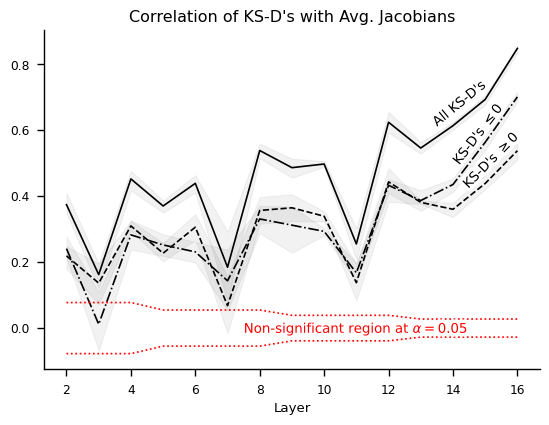

In [180]:
crits = df_corr_whole_all['Criterion'].unique()
styles = ['solid', 'dashed', 'dashdot', 'dotted', 'dotted']
colors = ['black', 'black', 'black', 'red', 'red']

for c, s, col in zip(crits, styles, colors):
    sns.lineplot(data=df_corr_whole_all[df_corr_whole_all['Criterion'] == c], x='Layer', y='Correlation KS-D with Avg. Jac.', linestyle=s, color=col, err_kws={'alpha': 0.05}, legend=False, label=c)
l = plt.gca().get_lines()

# df_r_crit_fb = df_corr_whole_all[(df_corr_whole_all['Criterion'].str.contains('Critical')) & (df_corr_whole_all['Network'] == 1)]
# plt.gca().fill_between(df_r_crit_fb['Layer'], -df_r_crit_fb['Correlation KS-D with Avg. Jac.'], df_r_crit_fb['Correlation KS-D with Avg. Jac.'], label='Region')

labelLines(l, align=[True, True, True, False], xvals=[14.2, 15.2, 14.8, 11.0], yoffsets=[0.05, 0.05, 0.05, -0.0425]);
# custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[2].get_linestyle()),
#                 ]
# plt.gca().legend(custom_lines, crits, ncols=2, loc=loc, frameon=False, title="Criterion")
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Avg. Jacobians", fontsize='large')
sns.despine()


In [187]:
# DONE: Check if the last layer gradient correlation is similar to the last layer weight correlation
#   single-head cifar
save_model_path = r'/mnt/raid/data/chebykin/saved_models/14_33_on_September_16/optimizer=SGD|batch_size=128|lr=0.1|connectivities_lr=0.0|chunks=[64|_64|_64|_128|_128|_128|_128|_256|_256|_256|_256|_512|_512|_512|_512]|architecture=binmatr2_resnet18|width_mul=1|weight_decay=0.000_240_model.pkl'
param_file = 'params/binmatr2_cifar_sgd1bias_fc_batch128_weightdecay3e-4_singletask.json'

me_cifar = ModelExplorer(save_model_path, param_file, model_to_use='my')

n_used_conns = 2
n_used_conns = 6
n_used_conns = 10
n_used_conns = 14
assume problem where cifar networks ignored the enable_bias parameter
n_used_conns = 2
n_used_conns = 6
n_used_conns = 10
n_used_conns = 14


In [225]:
neuron = 12
llw = me_cifar.model['all'].linear.weight.T[neuron, :].cpu().detach().numpy()
jacs = df_j_cifar[(df_j_cifar['Network'] == 1) & (df_j_cifar['Layer'] == 16) & (df_j_cifar['Neuron'] == neuron)]['Avg. Jacobian'].to_numpy()
np.corrcoef(llw, jacs)

array([[1., 1.],
       [1., 1.]])

# Imagenet

## KS Distribution plot

In [4]:
layers = range(0, 15)
df_list = []
for l in layers:
    ks_diff_path = f"wasser_dists/wasser_ks_diff_attr_hist_pretrained_imagenet_afterrelu_{l}.npy"
    ks_diff = np.load(ks_diff_path, allow_pickle=True).item()
    df = pd.DataFrame.from_dict(ks_diff)
    df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: KS_NAME})
    df["Layer"] = int(l)+2
    df["Network"] = 1
    df = df[["Network", "Layer", "Neuron", "Class", KS_NAME]]
    df_list.append(df)
df_ks_imagenet = pd.concat(df_list)
df_ks_imagenet

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference
0,1,2,0,0,0.339037
1,1,2,0,1,-0.235088
2,1,2,0,2,-0.243744
3,1,2,0,3,-0.340359
4,1,2,0,4,-0.183776
...,...,...,...,...,...
511995,1,16,511,995,-0.266546
511996,1,16,511,996,-0.292712
511997,1,16,511,997,-0.179515
511998,1,16,511,998,-0.170451


In [5]:
plot_ksd_distribution(df_ks_imagenet, title_suffix="on ImageNet-ResNet-18")

NameError: name 'plot_ksd_distribution' is not defined

## KSD Proportion Plot

In [281]:
def plot_ksd_proportion_imagenet(df, threshold=0.25, plot_cumsum=True):
    df_props = compute_df_props(df, threshold=threshold)

    nclasses = df_props["Number of classes"].unique()[:-1]
    nclasses.sort()
    # return nclasses

    cp = sns.color_palette("blend:#FFF,#000", nclasses[-1]+1)
    cp.append("red")
    cp.reverse()
    SO = [f"KS-D > {threshold}", f"KS-D < {threshold}"]

    y = "Proportion of neurons (cumsum)" if plot_cumsum else "Proportion of neurons"
    loc = "lower center" if plot_cumsum else "upper center"

    ylabel = "Proportion of neurons with $\\leq n$ classes\nfulfilling the criterion" if plot_cumsum else "Proportion of neurons with exactly $n$ classes\nfulfilling the criterion"

    # xvals= [15.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 15.5, 0.0, 16.0, 0.0] if plot_cumsum else [2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.6, 2.0, 0.0, 14.5, 0.0, 15.5, 0.0]

    df_props = df_props[df_props['Criterion'] == SO[0]]

    for n in nclasses:
        try:
            cp[n]
        except:
            return cp, n
        sns.lineplot(data=df_props[df_props["Number of classes"] == n], x="Layer", y=y, style="Criterion", style_order=SO, errorbar=None, color=cp[n], label=f"{n}", legend=False)
    l = plt.gca().get_lines()

    # xvals_cleared = []
    # for (i, x) in enumerate(xvals):
    #     if x == 0:
    #         l[i].set_label("")
    #     else:
    #         xvals_cleared.append(x)

    labelLines(l, align=False)#, xvals=xvals_cleared);
    custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
                    Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
                    ]
    plt.gca().legend(custom_lines, SO, ncols=2, loc=loc, frameon=False, title="Criterion")
    plt.gca().set(ylabel=ylabel)
    sns.despine()

In [282]:
df_props = compute_df_props(df_ks_imagenet)

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=12.999999999999998, xmax=12.999999999999998, xval=13.652307692307692). Clipping it into the allowed range.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:216: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=10.0, xmax=10.0, xval=13.70076923076923). Clipping it into the allowed range.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:216: UserWarning: The value at position 3 in `xvals` is outside the range of its associated line (xmin=6.999999999999998, xmax=6.999999999999998, xval=13.749230769230769). Clipping it into the allowed range.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/l

ValueError: x label location is outside data range!

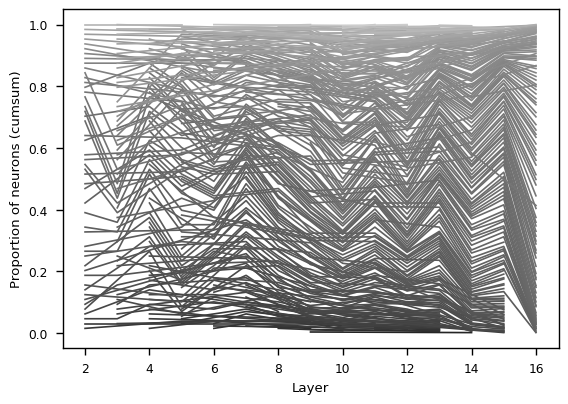

In [276]:
cp, n = plot_ksd_proportion_imagenet(df_ks_imagenet)

In [270]:
#TODO: plot has the issue that some lines cross -> comes from interpolation! Solution. stick to old value
#TODO: binning


321

In [285]:
df_props[df_props['Layer'] == 10].sort_values(by='Number of classes')

,Network,Layer,Number of classes,Neurons with class count,Neurons in layer,Proportion of neurons,Criterion,Proportion of neurons (cumsum)
656,1,10,45,1,256,0.003906,KS-D < 0.25,0.003906
657,1,10,62,1,256,0.003906,KS-D > 0.25,0.003906
657,1,10,67,1,256,0.003906,KS-D < 0.25,0.007812
658,1,10,85,1,256,0.003906,KS-D < 0.25,0.011719
658,1,10,95,1,256,0.003906,KS-D > 0.25,0.007812
...,...,...,...,...,...,...,...,...
803,1,10,380,1,256,0.003906,KS-D < 0.25,0.992188
805,1,10,382,1,256,0.003906,KS-D > 0.25,0.996094
804,1,10,390,1,256,0.003906,KS-D < 0.25,0.996094
806,1,10,400,1,256,0.003906,KS-D > 0.25,1.000000


In [18]:
def compute_df_props(df, threshold=0.25):
    # Filter with treshold
    df_proportions = df.copy()
    df_proportions[f"KS-D < {threshold}"] = df_proportions[KS_NAME] < -threshold
    df_proportions[f"KS-D > {threshold}"] = df_proportions[KS_NAME] > threshold
    
    df_proportions_counted = df_proportions.groupby(["Network", "Layer", "Neuron"]).sum()

    df_prop_list = []
    for crit in ["<", ">"]:
        df_proportions_ks_neurons_counted = df_proportions_counted.reset_index()[["Network", "Layer", f"KS-D {crit} {threshold}", "Neuron"]].groupby(["Network", "Layer", f"KS-D {crit} {threshold}"]).count().reset_index().rename(columns={"Neuron": "Neurons with class count"})
        
        # add zero counts on non counted class numbers
        ns = df_proportions_ks_neurons_counted['Network'].unique()
        ls = df_proportions_ks_neurons_counted['Layer'].unique()
        ksds = df_proportions_ks_neurons_counted[f"KS-D {crit} {threshold}"].unique()

        lns, lls, lksds = len(ns), len(ls), len(ksds)
        ns = ns.repeat(lls*lksds)
        ls = np.tile(ls.repeat(lksds), lns)
        ksds = np.tile(ksds, lns*lls)

        df_missing_zero_counts = pd.DataFrame({'Network': ns, 'Layer': ls, f"KS-D {crit} {threshold}": ksds})

        df_proportions_ks_neurons_counted = pd.merge(df_proportions_ks_neurons_counted, df_missing_zero_counts, on=['Network', 'Layer', f"KS-D {crit} {threshold}"], how='outer').fillna(0.0).sort_values(by=['Network', 'Layer', f"KS-D {crit} {threshold}"])

        df_proportions_neurons_counted = df_proportions_counted.reset_index()[["Network", "Layer", "Neuron"]].groupby(["Network", "Layer"]).count().reset_index().rename(columns={"Neuron": "Neurons in layer"})

        df_counts_merged = pd.merge(df_proportions_ks_neurons_counted, df_proportions_neurons_counted, on=["Network", "Layer"])

        df_counts_merged["Proportion of neurons"] = df_counts_merged["Neurons with class count"] / df_counts_merged["Neurons in layer"]
        df_counts_merged = df_counts_merged.rename(columns={f"KS-D {crit} {threshold}": "Number of classes"})
        df_counts_merged["Criterion"] = f"KS-D {crit} {threshold}"
        df_prop_list.append(df_counts_merged)

    df_props = pd.concat(df_prop_list)

    df_props["Proportion of neurons (cumsum)"] = df_props.groupby(["Network", "Layer", "Criterion"]).agg({"Proportion of neurons": 'cumsum'})
    return df_props


In [20]:
df = compute_df_props(df_ks_imagenet)

In [22]:
df[(df['Layer'] == 2) & (df['Criterion'] == 'KS-D < 0.25')]

,Network,Layer,Number of classes,Neurons with class count,Neurons in layer,Proportion of neurons,Criterion,Proportion of neurons (cumsum)
0,1,2,45,0.0,64,0.0,KS-D < 0.25,0.0
1,1,2,49,0.0,64,0.0,KS-D < 0.25,0.0
2,1,2,53,0.0,64,0.0,KS-D < 0.25,0.0
3,1,2,59,0.0,64,0.0,KS-D < 0.25,0.0
4,1,2,67,0.0,64,0.0,KS-D < 0.25,0.0
...,...,...,...,...,...,...,...,...
293,1,2,401,0.0,64,0.0,KS-D < 0.25,1.0
294,1,2,411,0.0,64,0.0,KS-D < 0.25,1.0
295,1,2,423,0.0,64,0.0,KS-D < 0.25,1.0
296,1,2,464,0.0,64,0.0,KS-D < 0.25,1.0
